In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/colab_projects/recommendation_system/nbs/

/content/gdrive/MyDrive/colab_projects/recommendation_system/nbs


In [4]:
import sys
sys.path.append("../src/")
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from config import *

In [5]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [6]:
df_train = pd.read_parquet("../data/processed/df_rating_movie_train.parquet")
df_val = pd.read_parquet("../data/processed/df_rating_movie_val.parquet")

In [7]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres
5355991,34760,4963,4.0,1008626350,Ocean's Eleven (2001),Crime|Thriller
16979199,110106,1183,1.5,1301889569,"English Patient, The (1996)",Drama|Romance|War
14781790,95711,4571,2.0,1009726295,Bill & Ted's Excellent Adventure (1989),Adventure|Comedy|Sci-Fi
5159343,33523,1411,4.0,1039513864,Hamlet (1996),Crime|Drama|Romance
18503349,119883,33660,4.0,1353051590,Cinderella Man (2005),Drama|Romance


In [8]:
movies_ids = list(set(list(df_train.movieId.unique()) + list(df_val.movieId.unique())))

In [9]:
users_ids = list(set(list(df_train.userId.unique()) + list(df_val.userId.unique())))

In [10]:
len(movies_ids)

59047

In [11]:
max(movies_ids)

209171

In [12]:
dict_movies = {}
index = 0
for ids in sorted(movies_ids):
    dict_movies[ids] = index
    index += 1

In [13]:
dict_users = {}
index = 0
for ids in sorted(users_ids):
    dict_users[ids] = index
    index += 1

In [14]:
df_train["movieId"] = df_train["movieId"].map(dict_movies)
df_val["movieId"] = df_val["movieId"].map(dict_movies)

df_train["userId"] = df_train["userId"].map(dict_users)
df_val["userId"] = df_val["userId"].map(dict_users)

In [15]:
df_train.describe()

,userId,movieId,rating,timestamp
count,2.000008e+07,2.000008e+07,2.000008e+07,2.000008e+07
mean,8.118888e+04,6.107920e+03,3.533854e+00,1.215613e+09
std,4.679203e+04,8.262760e+03,1.060744e+00,2.268744e+08
min,0.000000e+00,0.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.167000e+03,3.000000e+00,1.011760e+09
50%,8.091300e+04,2.855000e+03,3.500000e+00,1.198869e+09
75%,1.215560e+05,7.920000e+03,4.000000e+00,1.447207e+09
max,1.625400e+05,5.904600e+04,5.000000e+00,1.574328e+09


In [16]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres
5355991,34759,4857,4.0,1008626350,Ocean's Eleven (2001),Crime|Thriller
16979199,110105,1154,1.5,1301889569,"English Patient, The (1996)",Drama|Romance|War
14781790,95710,4466,2.0,1009726295,Bill & Ted's Excellent Adventure (1989),Adventure|Comedy|Sci-Fi
5159343,33522,1373,4.0,1039513864,Hamlet (1996),Crime|Drama|Romance
18503349,119882,9979,4.0,1353051590,Cinderella Man (2005),Drama|Romance


In [17]:
df_train.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
title         object
genres        object
dtype: object

In [18]:
for col in ["userId", "movieId", "rating"]:
    df_train[col] = df_train[col].astype(np.float32)
    df_val[col] = df_val[col].astype(np.float32)

In [19]:
num_unique_users=len(set(list(df_train.userId.unique()) + list(df_val.userId.unique())))
num_unique_movies=len(set(list(df_train.movieId.unique()) + list(df_val.movieId.unique())))

In [20]:
min_rating=min(df_train.rating.min(), df_val.rating.min())
max_rating=max(df_train.rating.max(), df_val.rating.max())

In [21]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Embedding, multiply, concatenate, Flatten, Input, Dense

In [22]:
users_input = Input(shape=(1,), name="users_input")
users_embedding = Embedding(num_unique_users + 1, EMBEDDING_SIZE, name="users_embeddings")(users_input)
users_bias = Embedding(num_unique_users + 1, 1, name="users_bias")(users_input)

movies_input = Input(shape=(1,), name="movies_input")
movies_embedding = Embedding(num_unique_movies + 1, EMBEDDING_SIZE, name="movies_embeddings")(movies_input)
movies_bias = Embedding(num_unique_movies + 1, 1, name="movies_bias")(movies_input)

dot_product_users_movies = multiply([users_embedding, movies_embedding])

input_terms = dot_product_users_movies + users_bias + movies_bias

input_terms = Flatten(name="fl_inputs")(input_terms)

output = Dense(1, activation="sigmoid", name="output")(input_terms) 
output = output * (max_rating - min_rating) + min_rating

In [23]:
model = Model(inputs=[users_input, movies_input], outputs=output)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embeddings (Embedding)    (None, 1, 50)        8127100     users_input[0][0]                
__________________________________________________________________________________________________
movies_embeddings (Embedding)   (None, 1, 50)        2952400     movies_input[0][0]               
______________________________________________________________________________________________

In [25]:
opt_adam = opt.Adam(lr = 0.005)
model.compile(optimizer=opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])

In [26]:
model.load_weights("../model/neural_collab_filtering_min_max_v1.h5")

In [27]:
for layer in model.layers:
    print(layer.name)

users_input
movies_input
users_embeddings
movies_embeddings
multiply
users_bias
tf.__operators__.add
movies_bias
tf.__operators__.add_1
fl_inputs
output
tf.math.multiply
tf.__operators__.add_2


In [28]:
dict_weights = {}
for layer in model.layers:
    if layer.name in ["users_embeddings", "movies_embeddings", "users_bias", "movies_bias"]:
        dict_weights[layer.name] = layer.weights

In [29]:
dict_weights

{'movies_bias': [<tf.Variable 'movies_bias/embeddings:0' shape=(59048, 1) dtype=float32, numpy=
  array([[ 1.0237963 ],
         [-0.06604583],
         [-0.4124465 ],
         ...,
         [-0.01887891],
         [-0.24327452],
         [ 0.0043013 ]], dtype=float32)>],
 'movies_embeddings': [<tf.Variable 'movies_embeddings/embeddings:0' shape=(59048, 50) dtype=float32, numpy=
  array([[ 1.0267459e+00, -1.3984728e+00,  9.5613635e-01, ...,
          -8.4093440e-01,  8.4898537e-01, -2.1363454e+00],
         [ 8.9872265e-01, -1.2944645e-02, -3.8406596e-01, ...,
           7.1511030e-01,  9.1650999e-01, -4.9048254e-01],
         [-2.1096662e-01, -1.2351556e-02, -1.1073297e+00, ...,
          -3.8032055e-02,  1.4504491e+00,  3.5762182e-01],
         ...,
         [ 1.4339294e-02, -1.8489398e-02, -1.3794243e-02, ...,
          -1.2065161e-02, -1.1167414e-03,  2.7633596e-02],
         [ 2.0024480e-01, -1.5721051e-01, -4.1243907e-02, ...,
          -1.5216771e-01,  1.8925081e-01, -1.9902429e

In [30]:
df_movies_embeddings = pd.DataFrame(dict_weights["movies_embeddings"][0].numpy())

In [31]:
df_movies_embeddings.columns = ["emb_" + str(col) for col in df_movies_embeddings.columns]

In [32]:
df_movies_embeddings

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345
1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483
2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622
3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473
4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59043,-0.113871,0.047957,0.027473,-0.039245,0.109119,-0.109187,-0.098774,0.129497,0.137834,-0.099372,0.107441,0.063560,-0.087322,0.106139,-0.096284,0.085086,0.090520,0.147950,-0.257447,0.128109,-0.127583,0.086395,-0.101408,-0.081303,0.075754,-0.117512,0.070500,0.095149,0.086251,0.205342,0.027998,0.069591,0.250721,0.147507,0.052512,-0.216845,-0.079042,0.206691,-0.102682,0.120575,0.122537,0.281615,0.319203,0.080215,-0.028682,0.045052,-0.143982,0.332225,-0.107093,-0.107904
59044,0.399472,-0.242021,0.096221,0.474222,0.422813,0.268074,-0.450773,-0.450087,-0.466176,0.364224,-0.175167,0.394352,0.463672,0.015695,0.131260,0.332473,-0.395601,-0.104557,0.057226,-0.378545,-0.046402,0.423807,0.247287,-0.350546,-0.472134,-0.065455,0.187521,0.173620,0.449283,-0.141695,-0.444006,0.466124,-0.341171,-0.130057,-0.381226,-0.137515,-0.298137,-0.448398,-0.377575,-0.393992,0.416186,-0.046224,0.462957,-0.415517,-0.405354,0.501878,0.376837,0.460616,-0.426892,0.463673
59045,0.014339,-0.018489,-0.013794,0.035838,-0.008989,0.000357,0.022988,0.032743,-0.026449,-0.043264,-0.025960,-0

In [33]:
len(df_movies_embeddings)

59048

In [34]:
df_train.movieId

5355991      4857.0
16979199     1154.0
14781790     4466.0
5159343      1373.0
18503349     9979.0
             ...   
4754081       582.0
11394247     3703.0
11583066    18114.0
16569013      530.0
8836972      5883.0
Name: movieId, Length: 20000076, dtype: float32

In [35]:
df_movies_embeddings.reset_index(inplace=True)

In [36]:
df_movies_embeddings.rename(columns={"index":"movieId"}, inplace=True)

In [37]:
df_movies_embeddings.head()

,movieId,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49
0,0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345
1,1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483
2,2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622
3,3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473
4,4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395


In [38]:
df_movies_embeddings = df_movies_embeddings.merge(df_train[["movieId", "title", "genres"]].drop_duplicates(), how="left", on="movieId")

In [39]:
len(df_movies_embeddings)

59048

In [40]:
df_movies_embeddings.head()

,movieId,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,title,genres
0,0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483,Jumanji (1995),Adventure|Children|Fantasy
2,2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622,Grumpier Old Men (1995),Comedy|Romance
3,3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395,Father of the Bride Part II (1995),Comedy


In [41]:
from sklearn.manifold import TSNE

In [42]:
vec_tsne = TSNE(n_components=2).fit_transform(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])

In [43]:
vec_tsne.shape

(59048, 2)

In [44]:
df_movies_embeddings["tsne_0"] = vec_tsne[:, 0]
df_movies_embeddings["tsne_1"] = vec_tsne[:, 1]

In [45]:
df_movies_embeddings.to_excel("../reports/movies_embessings.xlsx", index=False)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

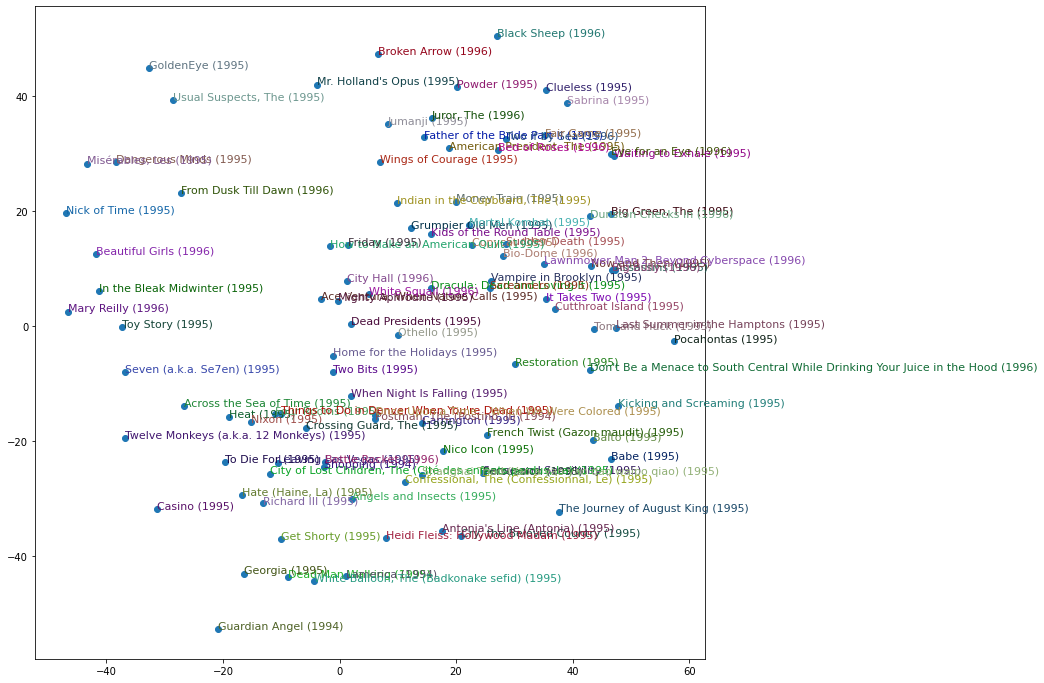

In [47]:
plt.figure(figsize=(12,12))
plt.scatter(df_movies_embeddings.tsne_0[:100], df_movies_embeddings.tsne_1[:100])
for i, x, y in zip(df_movies_embeddings.title[:100], df_movies_embeddings.tsne_0[:100], df_movies_embeddings.tsne_1[:100]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

In [48]:
from sklearn.cluster import KMeans
km = KMeans(100, random_state=101)
km.fit(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])
clusters = km.predict(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])

In [49]:
clusters

array([40, 69, 51, ...,  1,  1,  1], dtype=int32)

In [50]:
df_movies_embeddings["cluster_n10"] = clusters

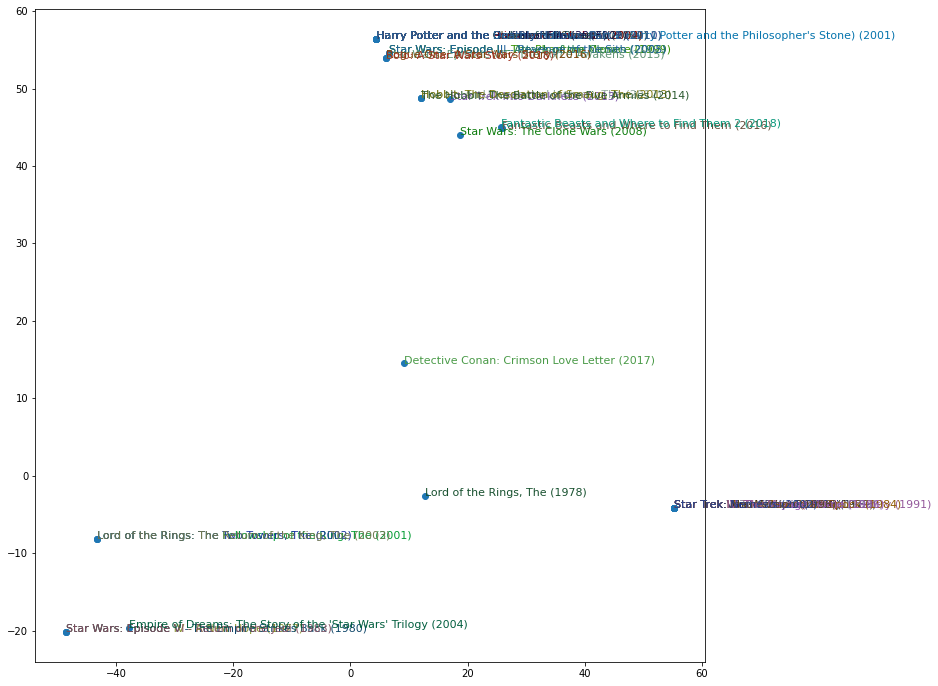

In [51]:
c = 84
plt.figure(figsize=(12,12))
plt.scatter(df_movies_embeddings.tsne_0[df_movies_embeddings.cluster_n10 == c], 
            df_movies_embeddings.tsne_1[df_movies_embeddings.cluster_n10 == c])
for i, x, y in zip(df_movies_embeddings.title[df_movies_embeddings.cluster_n10 == c], 
                   df_movies_embeddings.tsne_0[df_movies_embeddings.cluster_n10 == c], 
                   df_movies_embeddings.tsne_1[df_movies_embeddings.cluster_n10 == c]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)

In [ ]:
df_movies_embeddings.cluster_n10.value_counts(dropna=False).sort_values()

56       4
81       7
84      40
18      59
83     124
0      160
5      185
63     185
38     188
40     195
69     200
54     207
94     233
20     235
50     254
89     255
4      256
71     256
65     262
24     268
76     270
91     282
93     286
92     289
26     295
58     296
85     299
27     302
86     308
87     309
12     310
51     314
6      314
48     318
66     326
13     326
70     330
80     339
68     343
44     351
28     354
62     357
16     358
10     359
39     361
42     361
45     363
21     372
37     381
53     382
47     383
77     389
9      389
14     390
64     393
11     397
31     403
29     406
33     420
8      423
41     429
74     429
46     435
67     435
57     437
19     439
98     448
22     454
79     481
61     486
7      486
17     490
3      495
43     497
2      532
97     537
90     542
52     543
73     557
82     561
30     572
78     618
25     637
96     645
88     659
32     671
60     702
23     750
99     863
72     893
59    1018

In [ ]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==56][["title", "genres"]]

,title,genres
6416,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
10834,Pirates of the Caribbean: Dead Man's Chest (2006),Action|Adventure|Fantasy
11603,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy
16421,Pirates of the Caribbean: On Stranger Tides (2...,Action|Adventure|Fantasy|IMAX


In [ ]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==81][["title", "genres"]]

,title,genres
5622,Faces of Death 2 (1981),Documentary|Horror
5623,Faces of Death (1978),Documentary|Horror
5624,Faces of Death 3 (1985),Documentary|Horror
5625,Faces of Death 4 (1990),Documentary|Horror
5626,Faces of Death 5 (1996),Documentary|Horror
5627,Faces of Death 6 (1996),Documentary|Horror
5628,Faces of Death: Fact or Fiction? (1999),Documentary|Horror


In [ ]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==84][["title", "genres"]]

,title,genres
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
324,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi
1166,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1179,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
1321,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
1335,Star Trek: The Motion Picture (1979),Adventure|Sci-Fi
1336,Star Trek VI: The Undiscovered Country (1991),Action|Mystery|Sci-Fi
1337,Star Trek V: The Final Frontier (1989),Action|Sci-Fi
1338,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller
1339,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi


In [ ]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==18][["title", "genres"]]

,title,genres
3692,X-Men (2000),Action|Adventure|Sci-Fi
5241,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller
6221,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller
6411,Hulk (2003),Action|Adventure|Sci-Fi
7923,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX
10000,Batman Begins (2005),Action|Crime|IMAX
10802,X-Men: The Last Stand (2006),Action|Sci-Fi|Thriller
10888,Superman Returns (2006),Action|Adventure|Sci-Fi|IMAX
11558,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX
11639,Fantastic Four: Rise of the Silver Surfer (2007),Action|Adventure|Sci-Fi


In [ ]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==83][["title", "genres"]]

,title,genres
5827,"Man Who Saves the World, The (Dünyayi Kurtaran...",Adventure|Sci-Fi
9515,Elektra (2005),Action|Adventure|Crime|Drama
11125,Stormbreaker (Alex Rider: Operation Stormbreak...,Action|Children
11244,Eragon (2006),Action|Adventure|Fantasy
11292,Happily N'Ever After (2007),Animation|Children|Comedy
12821,Twilight (2008),Drama|Fantasy|Romance|Thriller
13055,Hotel for Dogs (2009),Adventure|Children|Comedy
13207,Dragonball Evolution (2009),Action|Adventure|Fantasy|Sci-Fi
13573,Race to Witch Mountain (2009),Adventure|Children|Fantasy|Sci-Fi|Thriller
13985,"Twilight Saga: New Moon, The (2009)",Drama|Fantasy|Horror|Romance|Thriller


In [ ]:
df_movies_embeddings[df_movies_embeddings.cluster_n10==0][["title", "genres"]]

,title,genres
75,Screamers (1995),Action|Sci-Fi|Thriller
323,Tales from the Crypt Presents: Demon Knight (1...,Horror|Thriller
598,Candyman: Farewell to the Flesh (1995),Fantasy|Horror
603,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi
824,Tales from the Crypt Presents: Bordello of Blo...,Comedy|Horror
870,Halloween: The Curse of Michael Myers (Hallowe...,Horror|Thriller
1078,Children of the Corn IV: The Gathering (1996),Horror
1288,Amityville 1992: It's About Time (1992),Horror
1289,Amityville 3-D (1983),Horror
1290,Amityville: Dollhouse (1996),Horror


In [ ]:
df_movies_embeddings.head()

,movieId,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,title,genres,tsne_0,tsne_1,cluster_n10
0,0,1.026746,-1.398473,0.956136,-0.793540,-0.916571,-0.959500,-0.747906,2.152045,0.836777,-1.242968,-0.116496,-0.414062,1.276287,-0.744861,-0.990196,-1.074888,1.051173,-0.782372,1.097696,-0.328867,-1.122463,0.318876,-0.484412,-0.339177,1.077130,-1.450224,0.858083,0.498059,-0.873023,-0.714399,1.404529,-1.741942,-1.191443,1.511502,0.710762,2.372844,1.119831,0.430395,1.106377,0.592358,-1.458885,-0.364975,0.665871,2.050426,-0.942531,1.115709,0.466503,-0.840934,0.848985,-2.136345,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49.082169,17.846102,40
1,1,0.898723,-0.012945,-0.384066,-0.681677,-0.483994,-0.087545,0.598605,1.089351,0.659315,0.087863,-0.292864,0.828796,0.786723,-0.774632,0.766871,-0.568207,0.998685,-0.380691,0.767468,0.032933,-0.271531,-0.188213,0.333563,0.894873,1.500248,-1.296165,1.084011,0.455358,0.844637,-0.431339,-0.565422,-0.673891,0.185420,-0.617755,-0.910657,1.368186,-0.432756,-0.823225,1.082292,0.455676,0.171653,0.029001,0.682210,0.374412,0.400584,0.414307,-0.604428,0.715110,0.916510,-0.490483,Jumanji (1995),Adventure|Children|Fantasy,22.197325,28.817272,69
2,2,-0.210967,-0.012352,-1.107330,-0.147138,-0.917762,-0.288528,0.660817,-2.311443,0.272432,-0.678423,0.729091,0.870351,2.147812,-0.331530,0.999358,0.475132,-1.359431,0.280140,1.226199,-0.815805,0.620428,0.720316,0.474567,-0.484376,-0.244890,-0.785984,-0.252487,-0.122231,-2.053999,-1.139868,-0.935910,-0.573419,1.125799,0.233294,0.591941,0.958921,0.775308,-0.170243,1.175283,0.138110,0.886286,-0.069861,0.215533,-1.217830,-0.229080,1.651977,-1.413277,-0.038032,1.450449,0.357622,Grumpier Old Men (1995),Comedy|Romance,36.721039,40.471062,51
3,3,1.334751,-0.197082,1.269866,0.201164,-0.713404,-0.466800,1.030000,0.078287,-0.447358,-0.304330,-0.824528,0.548722,-0.197455,0.725253,-1.102959,-1.277388,-0.725040,1.210764,0.653375,-0.546588,1.189015,-1.272074,-0.493265,-1.406017,-1.495447,0.476229,-1.590091,-0.649875,1.224160,1.888840,-0.228044,-0.850122,1.073607,0.760687,-0.946119,0.668396,0.676795,0.228158,1.439400,-0.641284,-0.184584,-1.208226,0.635853,0.358675,-0.714043,-0.747157,0.428771,0.825602,-0.876244,-1.477473,Waiting to Exhale (1995),Comedy|Drama|Romance,23.925772,37.889164,52
4,4,-0.012554,1.055383,-0.414126,0.713457,-1.700487,-0.762121,-0.214207,-0.723245,0.676640,-1.097177,-0.326715,0.916526,1.596397,-0.386702,-0.113742,0.043177,0.407636,1.011710,-1.076170,-1.053000,0.751997,-0.493683,0.431795,0.529298,0.858416,0.307859,-0.798146,-0.896746,-1.085537,-1.376089,-0.124993,-0.837178,0.138893,-1.003447,0.639740,1.822576,0.618120,0.177249,1.849487,-1.244021,-0.489514,0.850354,0.571320,-0.602266,-0.604635,0.396561,0.374626,-1.323830,0.937092,0.811395,Father of the Bride Part II (1995),Comedy,19.100960,34.700489,25


In [ ]:
df_movies_embeddings["bias"] = dict_weights["movies_bias"][0].numpy()

In [ ]:
df_movies_embeddings[["title", "bias"]].sort_values("bias", ascending=False)[:10]

,title,bias
38361,Planet Earth (2006),2.594953
314,"Shawshank Redemption, The (1994)",2.511874
42806,Band of Brothers (2001),2.306056
42953,Planet Earth II (2016),2.294770
840,"Godfather, The (1972)",2.138968
49,"Usual Suspects, The (1995)",1.984496
522,Schindler's List (1993),1.966990
31620,The Blue Planet (2001),1.905681
43172,Cosmos,1.890394
46627,Blue Planet II (2017),1.882246


In [ ]:
df_top_review = df_train.groupby(["title"]).agg({"rating": "mean", "userId": "count"}).rename(columns={"userId": "n_reviews"})
df_top_review = df_top_review[df_top_review.n_reviews > 100]
df_top_review.sort_values("rating", ascending=False)[:10]

,rating,n_reviews
title,,
Planet Earth II (2016),4.484270,890
Planet Earth (2006),4.475857,1429
"Shawshank Redemption, The (1994)",4.413228,65090
Band of Brothers (2001),4.398072,1089
Cosmos,4.347926,217
"Godfather, The (1972)",4.325421,42190
Blue Planet II (2017),4.301905,525
"Usual Suspects, The (1995)",4.284186,44184
The Blue Planet (2001),4.277897,466
